## Initial imports

In [1]:
import scm.plams as plams
from scm.params import ParAMSJob, ResultsImporter
import matplotlib.pyplot as plt

## Initialize PLAMS environment

In [2]:
plams.init()

PLAMS working folder: /home/hellstrom/temp/temp-BiN-2024-Feb-28/plams_workdir.003


## Initialize results importer

In [3]:
ri = ResultsImporter()

## Initial water molecule structure

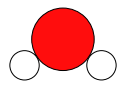

In [4]:
molecule = plams.from_smiles("O")
for at in molecule:
    at.properties = plams.Settings()

plams.plot_molecule(molecule)

## Reference bond scan #1: O-H

In [5]:
s = plams.Settings()
s.input.ams.Task = "PESScan"
s.input.ams.PESScan.ScanCoordinate = [plams.Settings()]
# Scan O-H bond from 0.8 to 1.2 angstrom in 7 steps
s.input.ams.PESScan.ScanCoordinate[0].Distance = ["1 2 0.8 1.2"]
s.input.ams.PESScan.ScanCoordinate[0].nPoints = 7
# CalcPropertiesAtPESPoints is required to be able to extract the forces later
s.input.ams.PESScan.CalcPropertiesAtPESPoints = "Yes"
s.input.ForceField.Type = "UFF"
s.runscript.nproc = 1

In [6]:
refjob1 = plams.AMSJob(settings=s, molecule=molecule, name="OH_scan")
refjob1.run();

[28.02|12:53:57] JOB OH_scan STARTED
[28.02|12:53:57] JOB OH_scan RUNNING
[28.02|12:53:57] JOB OH_scan FINISHED
[28.02|12:53:57] Job OH_scan reported warnings. Please check the output
[28.02|12:53:57] JOB OH_scan SUCCESSFUL


``add_pesscan_singlepoints`` will give points that ARE used for training/validation:

In [7]:
ri.add_pesscan_singlepoints(refjob1, properties=["energy", "forces"])

["energy('OH_scan_frame048')",
 "energy('OH_scan_frame097')",
 "energy('OH_scan_frame154')",
 "energy('OH_scan_frame168')",
 "energy('OH_scan_frame182')",
 "energy('OH_scan_frame196')",
 "energy('OH_scan_frame210')",
 "forces('OH_scan_frame048')",
 "forces('OH_scan_frame097')",
 "forces('OH_scan_frame154')",
 "forces('OH_scan_frame168')",
 "forces('OH_scan_frame182')",
 "forces('OH_scan_frame196')",
 "forces('OH_scan_frame210')"]

``add_singlejob`` with ``task="PESScan"`` gives a job that is used neither for training nor validation. Instead it will be part of the "test set", no matter if it's given in the training or validation sets in the input.

In [8]:
ri.add_singlejob(refjob1, task="PESScan", properties="pes")

["pes('OH_scan', relative_to=3)"]

## Reference bond scan #2: H-H

In [9]:
s = plams.Settings()
s.input.ams.Task = "PESScan"
s.input.ams.PESScan.ScanCoordinate = [plams.Settings()]
# Scan H-H distance from 0.8 to 1.2 angstrom in 7 steps
s.input.ams.PESScan.ScanCoordinate[0].Distance = ["3 2 1.2 1.8"]
s.input.ams.PESScan.ScanCoordinate[0].nPoints = 7
# CalcPropertiesAtPESPoints is required to be able to extract the forces later
s.input.ams.PESScan.CalcPropertiesAtPESPoints = "Yes"
s.input.ForceField.Type = "UFF"
s.runscript.nproc = 1
refjob2 = plams.AMSJob(settings=s, molecule=molecule, name="HH_scan")
refjob2.run();

[28.02|12:53:58] JOB HH_scan STARTED
[28.02|12:53:58] JOB HH_scan RUNNING
[28.02|12:53:58] JOB HH_scan FINISHED
[28.02|12:53:58] Job HH_scan reported warnings. Please check the output
[28.02|12:53:58] JOB HH_scan SUCCESSFUL


For the H-H, we will *only* add it to the "test set" with task PESScan.

This will clearly illustrate that while the O-H bond scan is well reproduced by the trained model, the H-H scan will not be well reproduced.

In [10]:
ri.add_singlejob(refjob2, task="PESScan", properties="pes")

["pes('HH_scan', relative_to=4)"]

## Reference geometry optimization

In [11]:
s = plams.Settings()
s.input.ams.Task = "GeometryOptimization"
s.input.ForceField.Type = "UFF"
s.runscript.nproc = 1

In [12]:
refjob3 = plams.AMSJob(settings=s, molecule=molecule, name="geometry_optimization")
refjob3.run();

[28.02|12:53:58] JOB geometry_optimization STARTED
[28.02|12:53:58] JOB geometry_optimization RUNNING
[28.02|12:53:58] JOB geometry_optimization FINISHED
[28.02|12:53:58] JOB geometry_optimization SUCCESSFUL


``add_trajectory_singlepoints`` will give points that ARE used for training/validation:

In [13]:
ri.add_trajectory_singlepoints(refjob3, properties=["energy", "forces"], N=5, data_set="validation_set")

["energy('geometry_optimization_frame001')",
 "energy('geometry_optimization_frame009')",
 "energy('geometry_optimization_frame017')",
 "energy('geometry_optimization_frame025')",
 "energy('geometry_optimization_frame034')",
 "forces('geometry_optimization_frame001')",
 "forces('geometry_optimization_frame009')",
 "forces('geometry_optimization_frame017')",
 "forces('geometry_optimization_frame025')",
 "forces('geometry_optimization_frame034')"]

``add_singlejob`` with ``task="GeometryOptimization"`` gives a job that is used neither for training nor validation. Instead it will be part of the "test set", no matter if it's given in the training or validation sets in the input.

In [14]:
ri.add_singlejob(refjob3, task="GeometryOptimization", properties=["energy", "distance(0,1)"])

["energy('geometry_optimization')", "distance('geometry_optimization',0,1)"]

## Store the reference results in ParAMS yaml format

Use ``ResultsImporter.store()`` to store all the data in the results importer in the ParAMS .yaml format:

In [15]:
yaml_dir = "yaml_ref_data"
ri.store(yaml_dir, backup=False)

['yaml_ref_data/job_collection.yaml',
 'yaml_ref_data/results_importer_settings.yaml',
 'yaml_ref_data/training_set.yaml',
 'yaml_ref_data/validation_set.yaml']

## Set up and run a ParAMSJob for training ML Potentials

See the ParAMS MachineLearning documentation for all available input options.

Training the model may take a few minutes.

In [16]:
job = ParAMSJob.from_yaml(yaml_dir)
job.name = "params_training_ml_potential"
job.settings.input.Task = "MachineLearning"
job.settings.input.MachineLearning.CommitteeSize = 1  # train only a single model
job.settings.input.MachineLearning.MaxEpochs = 50
job.settings.input.MachineLearning.LossCoeffs.Energy = 10
job.settings.input.MachineLearning.Backend = "M3GNet"
job.settings.input.MachineLearning.M3GNet.Model = "UniversalPotential"
job.settings.input.MachineLearning.Target.Forces.Enabled = "No"
job.settings.input.MachineLearning.RunAMSAtEnd = "Yes"

In [17]:
job.run();

[28.02|12:53:58] JOB params_training_ml_potential STARTED
[28.02|12:53:58] JOB params_training_ml_potential RUNNING
[28.02|12:55:21] JOB params_training_ml_potential FINISHED
[28.02|12:55:21] JOB params_training_ml_potential SUCCESSFUL


## Results of the ML potential training

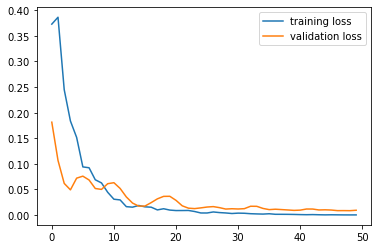

In [18]:
epoch, training_loss = job.results.get_running_loss(data_set="training_set")
plt.plot(epoch, training_loss)

epoch, validation_loss = job.results.get_running_loss(data_set="validation_set")
plt.plot(epoch, validation_loss)
plt.legend(["training loss", "validation loss"]);

If you set ``MachineLearning%RunAMSAtEnd`` (it is on by default), this will run the ML potential through AMS at the end of the fitting procedure, similar to the ParAMS SinglePoint task.

This means that also entries that are not used during the training/validation will be evaluated, for example the "pes" (energy vs. bond length) extractor and the "distance(0, 1)" (O-H optimized bond length) extractor.

## Plot results for actual training/validation sets

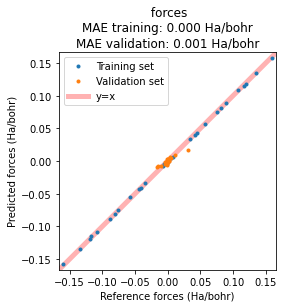

In [19]:
job.results.plot_simple_correlation("forces");

## Plot results for "test set"
These jobs or results were NOT used during the training/validation, even if the extractors were part of the training or validation sets!

The jobs were simply run at the end of the parametrization ("RunAMSAtEnd") and the results extracted at that points.

First let's plot the **energy vs. bond length** curves:

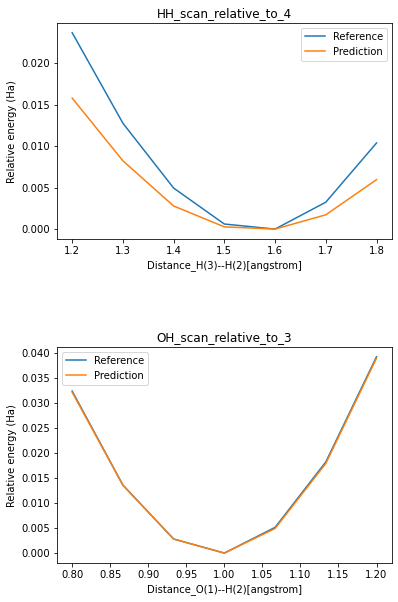

In [20]:
job.results.plot_all_pes()
plt.subplots_adjust(top=2, hspace=0.5)

Above we clearly see that the O-H scan is perfectly well reproduced by the trained model but not the H-H scan. This is because we called ``add_pesscan_singlepoints`` on the O-H bond scan reference job.

Then let's get the **reference and predicted optimized O-H bond length in water**:

In [21]:
print(job.results.get_data_set_evaluator().results["distance"].detailed_string())

#Reference     Prediction     Unit           Sigma    Weight    WSE*      Row*  Col*  Expression
#------------------------------------------------------------------------------------------------------------------------
+0.990         +0.991          angstrom       0.050    1.0000    0.000     0     0     distance('geometry_optimization',0,1)
#------------------------------------------------------------------------------------------------------------------------
#WSE*: Weighted Squared Error: weight*([reference-prediction]/sigma)**2
#Row*, Col*: For scalars both numbers are 0. For 1D arrays Col is 0.


## Finish PLAMS

In [22]:
plams.finish()

[28.02|12:55:21] PLAMS run finished. Goodbye
